In [446]:
import os
import subprocess
import time
import sys
import pandas as pd
import random
from collections import defaultdict
import numpy as np

In [2]:
kog_functions = pd.read_csv('/data/luojaa/uid_stats/kog_functions.tsv', sep = '\t').drop_duplicates("KOGID")
category_data = pd.read_csv('/data/luojaa/kegg_stats/kegg_categories.tsv', sep = '\t')
category_data = pd.merge(category_data, kog_functions, on = "KOGID", how = "outer").dropna()
module_data = category_data[category_data["CATEGORY_ID"].str.startswith("M")]
pathway_data = category_data[category_data["CATEGORY_ID"].str.contains("map")]

def extract_kogs(module):
    return list(set(module_data[module_data.CATEGORY_ID == module].KOGID))

modules = ["M00001", "M00009", "M00004", "M00082", "M00085", "M00048", "M00038", "M00055", "M00872", "M00946"]
glyco, tca, ppp, facid_init, facid_elon, pur, trp_meta, ngly, ogly, nosc = [extract_kogs(mod) for mod in modules]
mod2kogs = {mod:extract_kogs(mod) for mod in modules}

In [3]:
def parse_clean_annot(file):
    try:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1", "ec2", "ec3", "ec4", "ec5", "ec6", "ec7", "ec8", "ec9", "ec10"]).dropna(axis = 1, how = "all")
    except pd.errors.ParserError:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1"])
    data["ec"] = [mappings[0].replace("EC:", "") for mappings in data["ec1"].str.split("/")]
    data["confidence_ec1"] = [float(mappings[1]) for mappings in data["ec1"].str.split("/")]
    return data

In [4]:
proteinfer_swarmfile = "/data/luojaa/proteinfer/benchmark/output/tmp/reannotate_proteinfer.swarm"
ordered_infiles = []
with open(proteinfer_swarmfile, "r") as f:
    lines = f.readlines()
    for line in lines[6:]:
        ordered_infiles.append(line.strip().split(" ")[4].split("/")[-1].strip(".fasta"))

ordered_kogs = [file.split(".")[1] for file in ordered_infiles]

output_csvs = [f"/data/luojaa/CLEAN/app/results/inputs/{file}_maxsep.csv" for file in ordered_infiles]
kog2pids = defaultdict(list)
pois = set()
for i in range(len(output_csvs)):
    kog = ordered_kogs[i]
    pids = list(set(parse_clean_annot(output_csvs[i]).index))
    kog2pids[kog] += pids
    for pid in pids:
        pois.add(pid)

### homology transfer scores

In [5]:
hhsearch_results = pd.read_csv("/data/luojaa/kegg_hmm_db/search_keggseq_vskegg/search_results.cut.tsv", sep = "\t")

In [6]:
hhsearch_results_drep = hhsearch_results[hhsearch_results.Query != hhsearch_results.Target]

In [7]:
hhsearch_results_poi = hhsearch_results_drep[hhsearch_results_drep.Query.isin(pois)]

In [8]:
hhsearch_results_poi["KOGID"] = hhsearch_results_poi.Target.apply(lambda x: x.split("_")[0])

In [9]:
kog_ec = kog_functions[kog_functions.FUNCTION.str.contains("EC:")].reset_index().drop("index", axis = 1)
kog_ec["EC"] = kog_ec.FUNCTION.apply(lambda x: x.split("EC:")[1].strip("]"))
kog_single_ec = kog_ec[~kog_ec.EC.str.contains(" ")]

In [10]:
hhsearch_results_poi_ec = pd.merge(kog_single_ec, hhsearch_results_poi, how = "inner", on = "KOGID")

In [107]:
kog2pids_transform = defaultdict(list)
for key in kog2pids.keys():
    for value in kog2pids[key]:
        kog2pids_transform["KOGID_dom"] += [key]
        kog2pids_transform["Query"] += [value]
kog2pids_df = pd.DataFrame(kog2pids_transform)
kog2pids_df["KOGID"] = kog2pids_df["KOGID_dom"].apply(lambda x: x.split("_")[0])
pid2eclabel_df = pd.merge(kog2pids_df, kog_single_ec, on = "KOGID", how = "inner").drop(["KOGID_dom", "KOGID","FUNCTION"], axis = 1).rename(columns = {"EC": "EC_label"})
htransfer_benchmark_df = pd.merge(pid2eclabel_df, hhsearch_results_poi_ec, on = "Query", how = "inner")

In [23]:
def subset_df(kogid_dom, df):
    return df[(df.Target == kogid_dom) | (df.Query.isin(kog2pids[kogid_dom]))].reset_index().drop("index", axis = 1)

def prep_df_eval(df):
    df["EC_1_label"] = df["EC_label"].apply(lambda x: x.split(".")[0])
    df["EC_2_label"] = df["EC_label"].apply(lambda x: x.split(".")[1])
    df["EC_3_label"] = df["EC_label"].apply(lambda x: x.split(".")[2])
    df["EC_4_label"] = df["EC_label"].apply(lambda x: x.split(".")[3])
    df["EC_1_pred"] = df["EC"].apply(lambda x: x.split(".")[0])
    df["EC_2_pred"] = df["EC"].apply(lambda x: x.split(".")[1])
    df["EC_3_pred"] = df["EC"].apply(lambda x: x.split(".")[2])
    df["EC_4_pred"] = df["EC"].apply(lambda x: x.split(".")[3])
    return df

In [46]:
[1,2,3][:3]

[1, 2, 3]

In [250]:
def calc_stats(df, ec, ec_pos, kogid_dom):
    num_members = len(set(df[df.Query.isin(kog2pids[kogid_dom])].Query))
    label, pred = df.EC_label.apply(lambda x: ".".join(x.split(".")[:ec_pos + 1])), df.EC.apply(lambda x: ".".join(x.split(".")[:ec_pos + 1]))
    TP = len(set(df[(label == pred) & (df.Query.isin(kog2pids[kogid_dom]))].Query))
    FP = len(set(df[label != ".".join(ec.split(".")[:ec_pos+1])].Query))
    FN = num_members - TP
    try:
        if TP == 0:
            return ["0","0"]
        sensitivity = TP / (TP + FN)
        precision = TP / (TP + FP)
        #print(str(TP), str(FP), str(FN), ec_pos)
        return [str(sensitivity), str(precision)]
    except ZeroDivisionError:
        return ["None", "None"]

In [198]:
def calc_stats_all(eval_df, fullec, kogid_dom):
    stats_nested = [calc_stats(eval_df, fullec, 0, kogid_dom), calc_stats(eval_df, fullec, 1, kogid_dom), calc_stats(eval_df, fullec, 2, kogid_dom), calc_stats(eval_df, fullec, 3, kogid_dom)]
    return "|".join([",".join([stats_nested[0][0], stats_nested[1][0], stats_nested[2][0], stats_nested[3][0]]),
                    ",".join([stats_nested[0][1], stats_nested[1][1], stats_nested[2][1], stats_nested[3][1]])])

In [212]:
kog, kog_dom = "K19873", "K19873_euk"
ec = kog_single_ec[kog_single_ec.KOGID == kog].EC.iloc[0]
htransfer_subset = subset_df(kog_dom, htransfer_benchmark_df)
htransfer_eval_df = prep_df_eval(htransfer_subset)
print(calc_stats_all(htransfer_eval_df, ec, kog_dom))

1.0,1.0,1.0,1.0|1.0,1.0,1.0,1.0


In [ ]:
for kog_dom in kog2pids.keys():
    kog=kog_dom.split("_")[0]
    try:
        try:
            ec = kog_single_ec[kog_single_ec.KOGID == kog].EC.iloc[0]
            htransfer_subset = subset_df(kog_dom, htransfer_benchmark_df)
            htransfer_eval_df = prep_df_eval(htransfer_subset)
            print(calc_stats_all(htransfer_eval_df, ec, kog_dom))
        except IndexError:
            print("None")
    except ZeroDivisionError:
        print("No hhsearch hits")

### clean scores

In [147]:
def parse_clean(file):
    kog_dom = file.split("/")[-1].split(".")[1].strip("_maxsep")
    kog = kog_dom.split("_")[0]
    try:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1", "ec2", "ec3", "ec4", "ec5", "ec6", "ec7", "ec8", "ec9", "ec10"]).dropna(axis = 1, how = "all")
    except pd.errors.ParserError:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1"])
    # get list of ecs each protein is annotated by
    data["ecs"] = ["|".join([row.iloc[colind].split("/")[0].replace("EC:", "") for colind in range(sum(~row.isnull()))]) for row in [data.loc[ind] for ind in data.index.tolist()]]
    #top ec summary stats
    data["ec"] = [mappings[0].replace("EC:", "") for mappings in data["ec1"].str.split("/")]
    data["confidence_ec1"] = [float(mappings[1]) for mappings in data["ec1"].str.split("/")]
    data["KOGID"] = [kog]*len(data)
    data["KOG_DOM"] = [kog_dom]*len(data)
    return data

In [419]:
# concat all dfs for regrouping
clean_benchmark_dfs = []
for i in range(len(output_csvs)):
    clean_output_df = parse_clean(output_csvs[i]).reset_index().rename(columns = {"protein_acc": "Query"})
    clean_benchmark_dfs.append(pd.merge(pid2eclabel_df, clean_output_df, on = "Query", how = "inner")[["Query","EC_label","ecs","ec1","KOGID","KOG_DOM"]])
clean_benchmark_concat = pd.concat(clean_benchmark_dfs).drop_duplicates()

In [420]:
tmp = subset_clean_df("K15634_euk", "5.4.2.11", clean_benchmark_concat)
tmp_eval = explode_ecs_cleandf(tmp)
calc_stats_all(tmp_eval, "5.4.2.11", "K15634_euk")

'0.0297029702970297,0.0297029702970297,0.0297029702970297,0|1.0,1.0,1.0,0'

In [421]:
def subset_clean_df(kogid_dom, ec_label, df):
    return df[(df.ecs.str.contains(ec_label)) | (df.Query.isin(kog2pids[kogid_dom]))].reset_index().drop("index", axis = 1)
def explode_ecs_cleandf(df):
    df["EC"] = df.ecs.str.split("|")
    return df.explode("EC")

In [423]:
for kog_dom in kog2pids.keys():
    kog=kog_dom.split("_")[0]
    try:
        ec = kog_single_ec[kog_single_ec.KOGID == kog].EC.iloc[0]
        clean_subset = subset_clean_df(kog_dom, ec, clean_benchmark_concat)
        clean_eval = explode_ecs_cleandf(clean_subset)
        print(calc_stats_all(clean_eval, ec, kog_dom))
    except IndexError:
        print("None")
    asdf

0.0297029702970297,0.0297029702970297,0.0297029702970297,0|1.0,1.0,1.0,0


NameError: name 'asdf' is not defined

### proteinfer scores

In [379]:
output_tsvs = [f"/data/luojaa/proteinfer/benchmark/output_unfiltered//{file}.tsv" for file in ordered_infiles]

In [468]:
def parse_proteinfer(file):
    data = pd.read_csv(file, sep='\t', index_col=0)
    
    data[['label_type', 'predicted_label']] = [label.split(':') for label in data.predicted_label]

    data_pfam = data[data.label_type == 'Pfam']
    data_EC = data[data.label_type == 'EC'].reset_index()
    if len(data_EC) == 0:
        return
    data_GO = data[data.label_type == 'GO']
    
    #data_EC = data_EC.reset_index().drop_duplicates('sequence_name', keep='last').set_index('sequence_name')
    #data_EC['defined_EC'] = [True if label[-1] != '-' else False for label in data_EC.predicted_label]
    
    # track which rows are essentially duplicates with less detail
    data_EC["next_row_more_detail"] = pd.Series(list(data_EC.predicted_label.apply(lambda x: x.count("-")))) > pd.Series(list(data_EC.predicted_label.apply(lambda x: x.count("-")))[1:] + [5])
    data_EC["next_row_same_query"] = pd.Series(list(data_EC.sequence_name)) == pd.Series(list(data_EC.sequence_name)[1:] + ["last_row_false"])
    data_EC["next_row_same_class"] = pd.Series(list(data_EC.predicted_label.apply(lambda x: x.replace("-", "").replace(".", "")))) == pd.Series(list(data_EC.predicted_label.apply(lambda x: "".join(x.replace("-", "").strip(".").split(".")[:-1])))[1:] + ["last_row_false"])
    
    kog_dom = file.split("/")[-1].split(".")[1].strip("_maxsep")
    kog = kog_dom.split("_")[0]
    data_EC["KOGID"] = [kog]*len(data_EC)
    data_EC["KOG_DOM"] = [kog_dom]*len(data_EC)
    return data_EC[~(data_EC.next_row_more_detail & data_EC.next_row_same_query & data_EC.next_row_same_class)]

In [475]:
# concat all dfs for regrouping
pinfer_benchmark_dfs = []
for i in range(len(output_tsvs)):
    try:
        pinfer_output_df = parse_proteinfer(output_tsvs[i]).rename(columns = {"sequence_name": "Query", "predicted_label":"EC"})
        pinfer_benchmark_dfs.append(pd.merge(pid2eclabel_df, pinfer_output_df, on = "Query", how = "inner")[["Query","EC","EC_label","KOGID","KOG_DOM"]])
    except AttributeError:
        # no ECs were annotatable in the proteins in this KOG
        pass
pinfer_benchmark_concat = pd.concat(pinfer_benchmark_dfs).drop_duplicates()

In [477]:
def subset_pinfer_df(kogid_dom, ec_label, df):
    return df[(df.EC == ec_label) | (df.Query.isin(kog2pids[kogid_dom]))].reset_index().drop("index", axis = 1)

In [480]:
data_EC

,sequence_name,predicted_label,confidence,description,label_type,next_row_more_detail,next_row_same_query,next_row_same_class,KOGID,KOG_DOM
3,I3PLR4,2.3.1.150,0.82,Salutaridinol 7-O-acetyltransferase.,EC,False,False,False,K22095,K22095_euk


In [457]:
data_EC

,sequence_name,predicted_label,confidence,description,label_type,next_row_more_detail,next_row_same_query,next_row_same_class,KOGID,KOG_DOM
2,I3PLR4,2.3.1.-,1.00,Transferring groups other than amino-acyl groups.,EC,True,True,False,K22095,K22095_euk
3,I3PLR4,2.3.1.150,0.82,Salutaridinol 7-O-acetyltransferase.,EC,False,False,False,K22095,K22095_euk


In [482]:
output_tsvs[-9]

'/data/luojaa/proteinfer/benchmark/output_unfiltered/M00946.K13395_euk.tsv'

In [447]:
K13395_euk

0.7129545454545455

In [ ]:
output_tsvs = [f"/data/luojaa/proteinfer/benchmark/output_unfiltered/{file}.tsv" for file in ordered_infiles]
proteinfer_
for i in range(len(ordered_infiles)):
    data_EC = parse_proteinfer(output_tsvs[i])
    try:
        toplabel, conf = [str(x) for x in list(data_EC.value_counts("predicted_label", normalize = True).reset_index().iloc[0,:])]
        #print(" ".join([toplabel, conf]))
        print(np.mean(data_EC[data_EC.predicted_label == toplabel].confidence))
    except AttributeError:
        print(f"None")
        
    #print(data_EC.value_counts("description"))

In [ ]:
for kog_dom in kog2pids.keys():
    kog=kog_dom.split("_")[0]
    try:
        ec = kog_single_ec[kog_single_ec.KOGID == kog].EC.iloc[0]
        pinfer_subset = subset_pinfer_df(kog_dom, ec, pinfer_benchmark_concat)
        print(calc_stats_all(pinfer_subset, ec, kog_dom))
    except IndexError:
        print("None")

# visualize stats

In [565]:
import seaborn as sns
import matplotlib.pyplot as plt

In [556]:
mod2desc = {"M00001": "Glycolysis", "M00009": "Citric acid cycle", "M00004": "Pentose phosphate pathway", "M00082":"Fatty acid biosynthesis, initiation", "M00085": "Fatty acid elongation in mitochondria", "M00048": "De novo purine biosynthesis", "M00038": "Tryptophan metabolism", "M00055": "N-glycan precursor biosynthesis", "M00872": "O-glycan biosynthesis, mannose type (core M3)", "M00946": "Noscapine biosynthesis"}

In [497]:
homology_transfer_stats = pd.read_csv("homology_transfer_stats.tsv", sep = "\t")
proteinfer_clean_stats = pd.read_csv("proteinfer_clean_stats.tsv", sep = "\t")
homology_transfer_stats["Module"] = homology_transfer_stats.Fasta.apply(lambda x: x.split(".")[0])
proteinfer_clean_stats["Module"] = proteinfer_clean_stats.Fasta.apply(lambda x: x.split(".")[0])

In [501]:
ht_melt = pd.melt(homology_transfer_stats, id_vars='Module', value_vars=[c for c in homology_transfer_stats if c.startswith('h')], value_name='statistic')
pc_melt = pd.melt(proteinfer_clean_stats, id_vars='Module', value_vars=[c for c in proteinfer_clean_stats if len(c) == 3], value_name='statistic')


In [503]:
allstats_melt = pd.concat([ht_melt, pc_melt])

In [577]:
order_dict_sens = {"hs1": 1, "ps1": 2, "cs1": 3, "hs2": 4, "ps2": 5, "cs2": 6, "hs3": 7, "ps3": 8, "cs3": 9, "hs4": 10, "ps4": 11, "cs4": 12}
order_dict_ppv = {"hp1": 1, "pp1": 2, "cp1": 3, "hp2": 4, "pp2": 5, "cp2": 6, "hp3": 7, "pp3": 8, "cp3": 9, "hp4": 10, "pp4": 11, "cp4": 12}

In [578]:
sens_melt = allstats_melt[allstats_melt.variable.apply(lambda x: x[1] == "s")].reset_index().drop("index", axis = 1)
ppv_melt = allstats_melt[allstats_melt.variable.apply(lambda x: x[1] == "p")].reset_index().drop("index", axis = 1)
sens_melt["order"] = sens_melt.variable.apply(lambda x: order_dict_sens[x])
ppv_melt["order"] = ppv_melt.variable.apply(lambda x: order_dict_ppv[x])
sens_melt.sort_values(["order", "Module"], inplace = True)
ppv_melt.sort_values(["order", "Module"], inplace = True)

In [579]:
m1_sens_melt = sens_melt[sens_melt.Module == "M00001"]

In [563]:
sns.set(style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (9, 6),      # width = 6, height = 9
            "figure.facecolor": "ivory",  # Figure colour
            "axes.facecolor": "ivory"})  # Axes colour

done


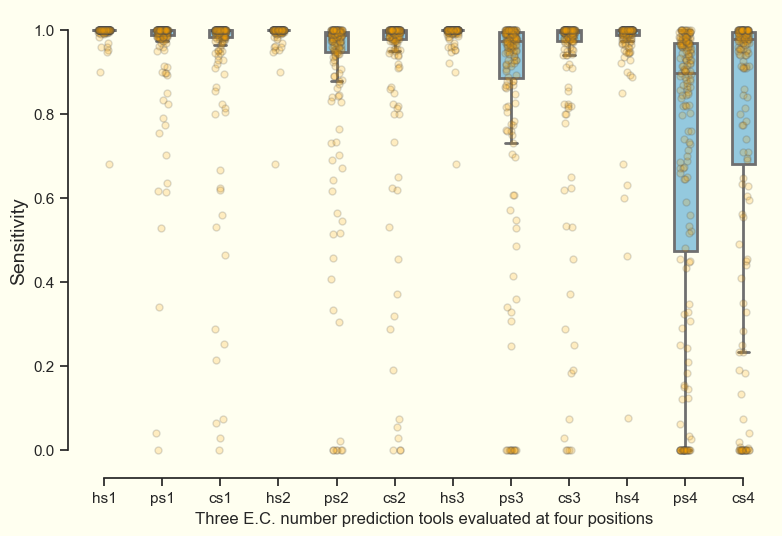

In [584]:
b = sns.boxplot(data = sens_melt, 
                x = "variable", 
                y = "statistic",
                width = 0.4,        # The width of the boxes
                color = "skyblue",  # Box colour
                linewidth = 2,      # Thickness of the box lines
                showfliers = False)  # Sop showing the fliers)
# Strip plot
b = sns.stripplot(data = sens_melt,          
                  x = "variable",      # x axis column from data
                  y = "statistic",      # y axis column from data
                  color = "orange", # Colours the dots
                  linewidth = 1,     # Dot outline width
                  alpha = 0.2)       # Makes them transparent

b.set_ylabel("Sensitivity", fontsize = 14)
b.set_xlabel("Three E.C. number prediction tools evaluated at four positions", fontsize = 12)
desc = mod2desc[module]
#b.set_title(f"Module {module}: {desc}", fontsize = 16)
# Remove axis spines
sns.despine(offset = 5, trim = True)


# Show the plot
b.get_figure();
#plt.close(b.get_figure())
print("done")

done
done
done
done
done
done
done
done
done
done


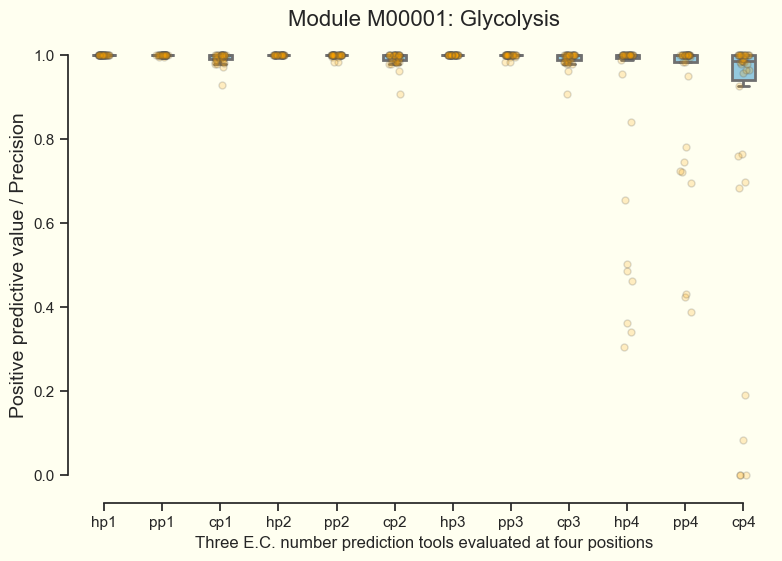

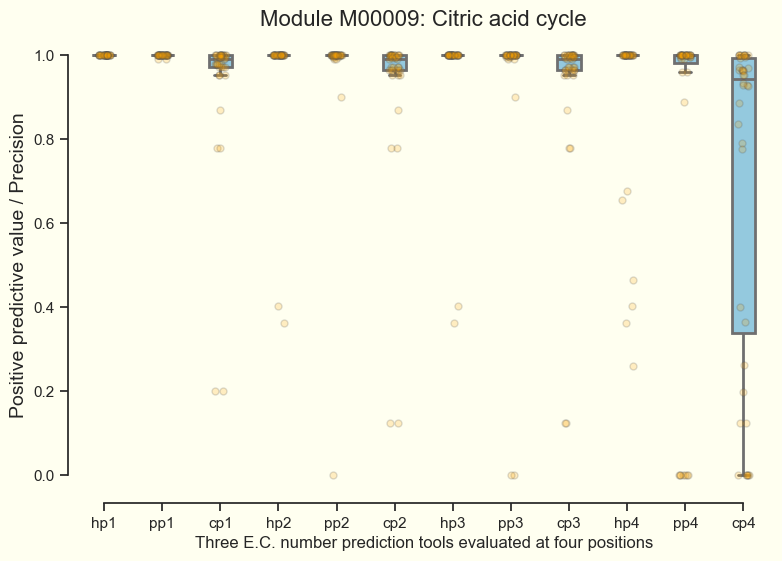

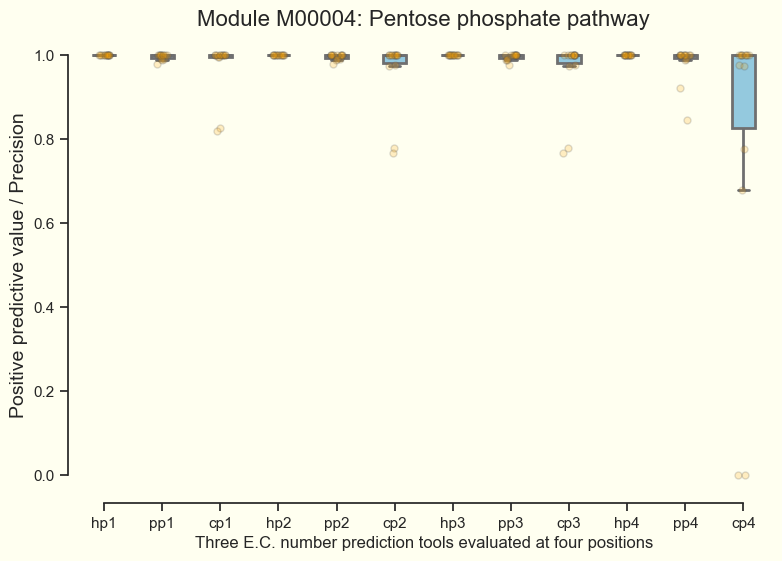

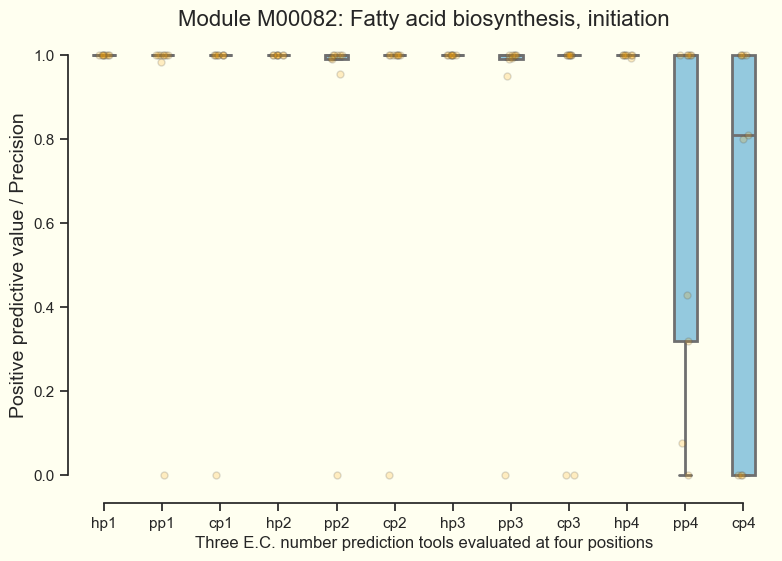

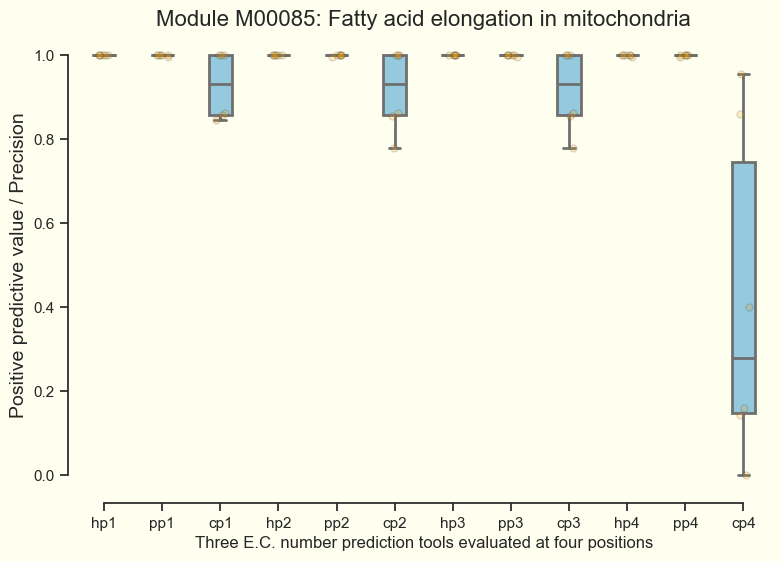

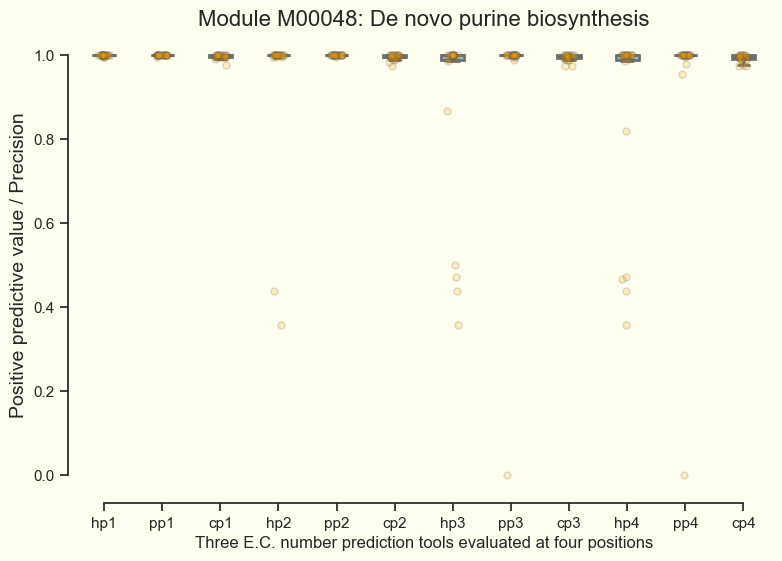

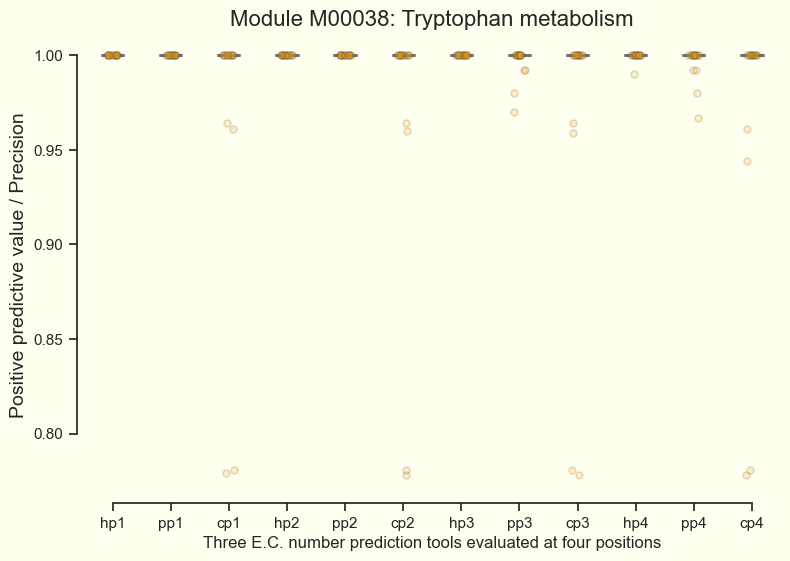

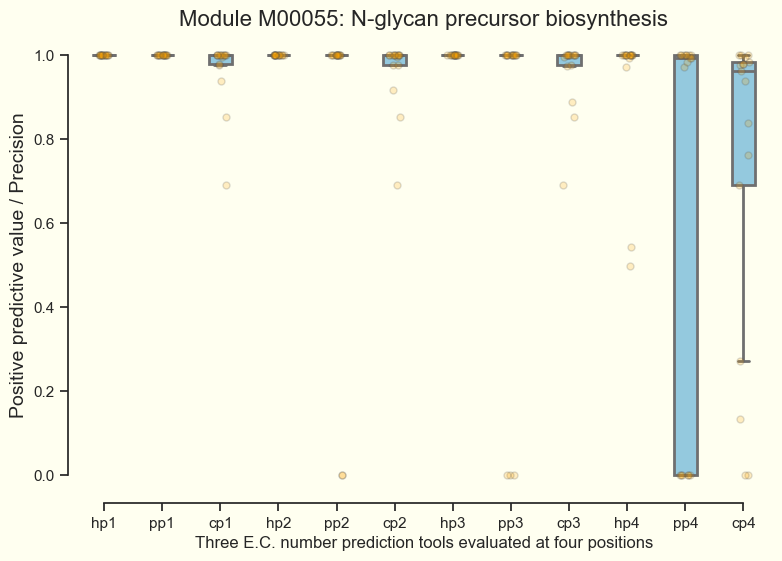

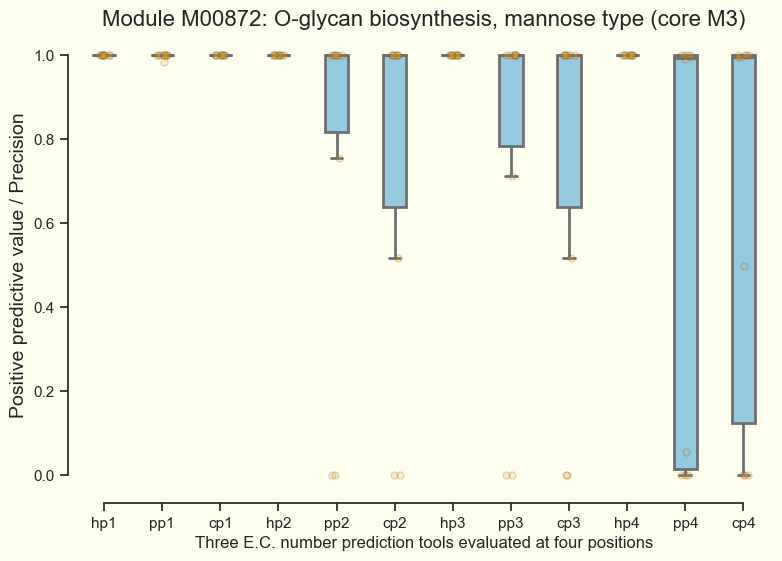

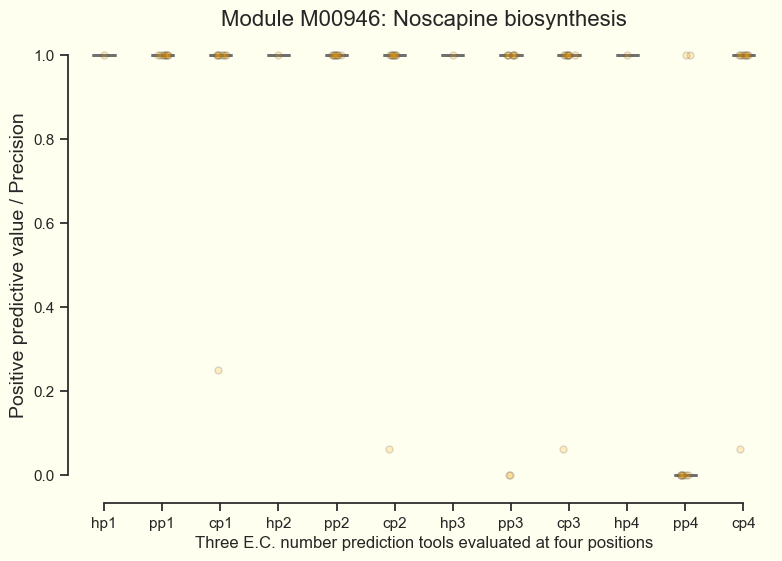

In [580]:
# ppv
for module in list(mod2desc.keys()):
    plt.figure()
    mod_ppv_melt = ppv_melt[ppv_melt.Module == module]
    b = sns.boxplot(data = mod_ppv_melt, 
                    x = "variable", 
                    y = "statistic",
                    width = 0.4,        # The width of the boxes
                    color = "skyblue",  # Box colour
                    linewidth = 2,      # Thickness of the box lines
                    showfliers = False)  # Sop showing the fliers)
    # Strip plot
    b = sns.stripplot(data = mod_ppv_melt,          
                      x = "variable",      # x axis column from data
                      y = "statistic",      # y axis column from data
                      color = "orange", # Colours the dots
                      linewidth = 1,     # Dot outline width
                      alpha = 0.2)       # Makes them transparent

    b.set_ylabel("Positive predictive value / Precision", fontsize = 14)
    b.set_xlabel("Three E.C. number prediction tools evaluated at four positions", fontsize = 12)
    desc = mod2desc[module]
    b.set_title(f"Module {module}: {desc}", fontsize = 16)
    # Remove axis spines
    sns.despine(offset = 5, trim = True)


    # Show the plot
    b.get_figure();
    #plt.close(b.get_figure())
    print("done")

done
done
done
done
done
done
done
done
done
done


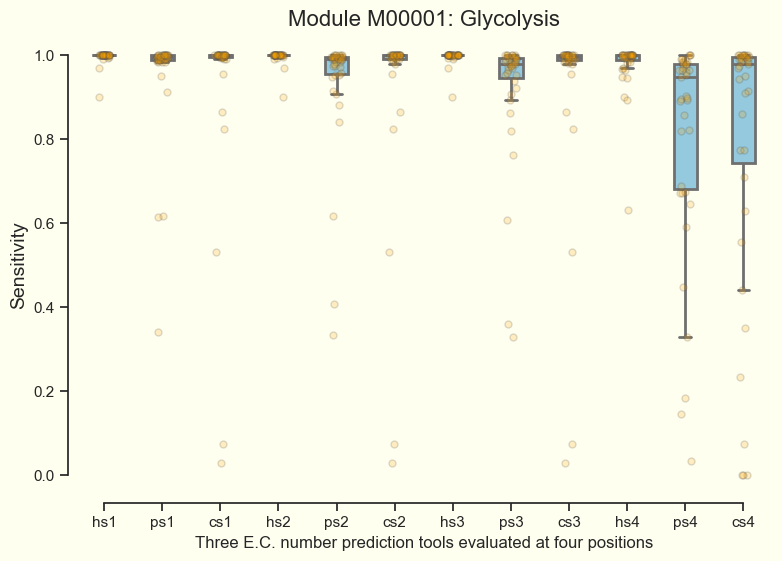

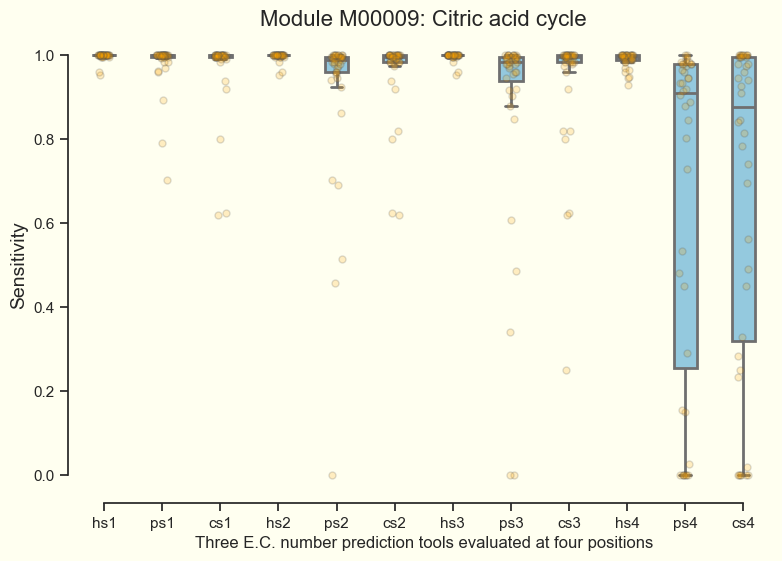

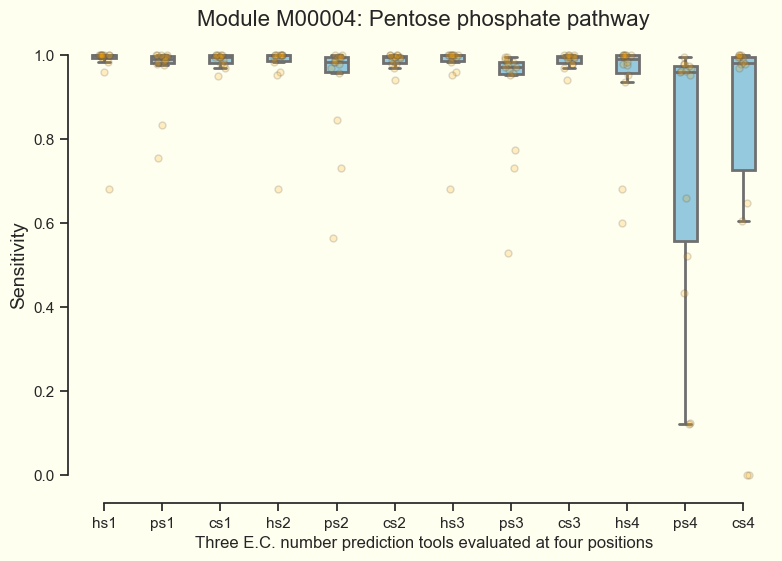

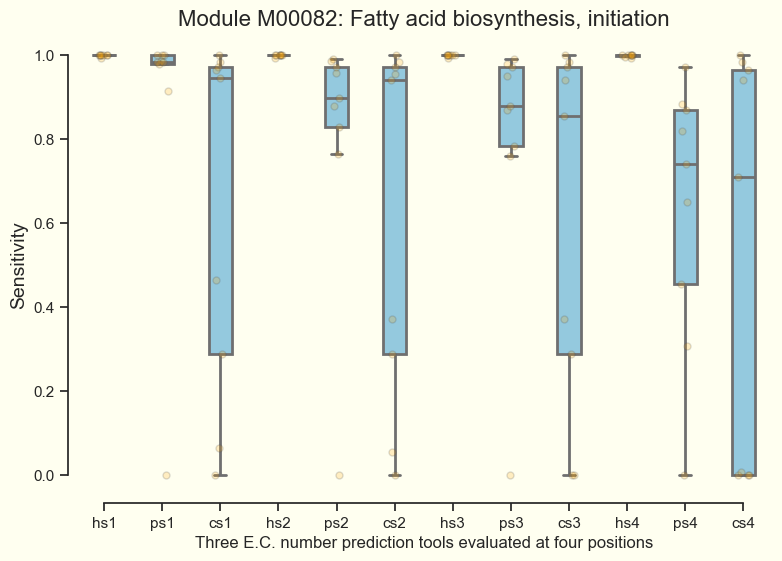

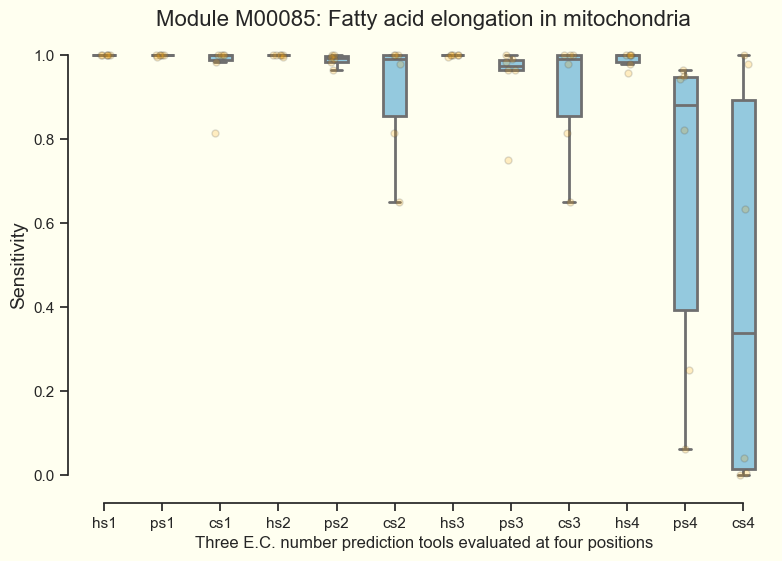

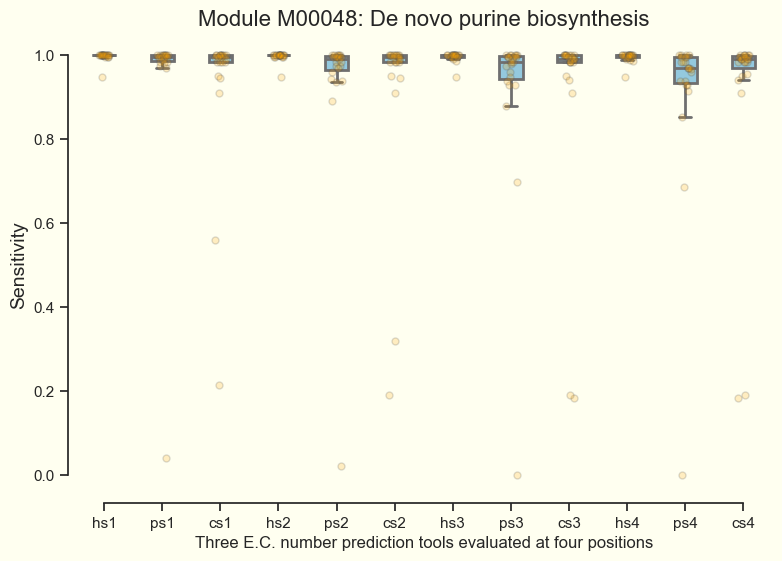

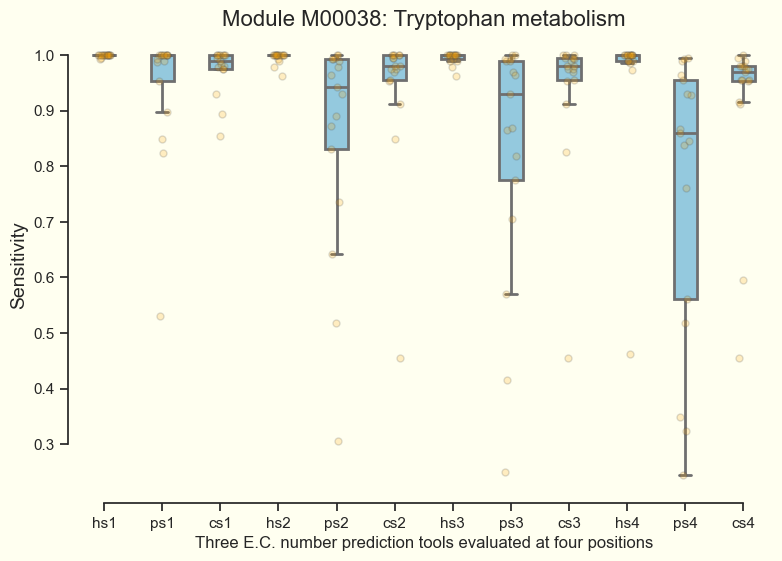

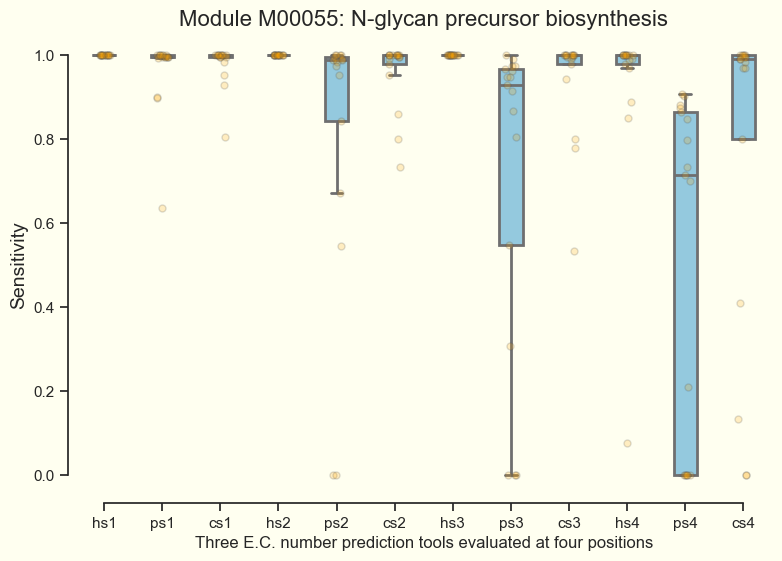

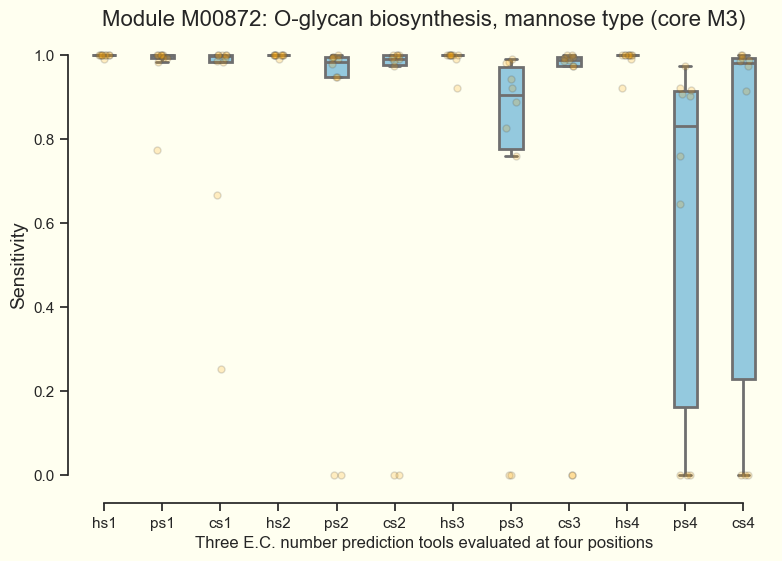

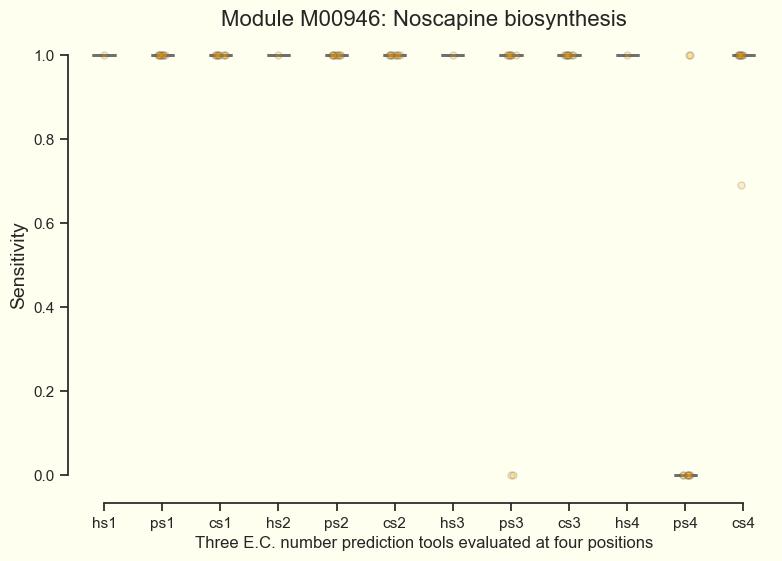

In [576]:
# sensitivity
for module in list(mod2desc.keys()):
    plt.figure()
    mod_sens_melt = sens_melt[sens_melt.Module == module]
    b = sns.boxplot(data = mod_sens_melt, 
                    x = "variable", 
                    y = "statistic",
                    width = 0.4,        # The width of the boxes
                    color = "skyblue",  # Box colour
                    linewidth = 2,      # Thickness of the box lines
                    showfliers = False)  # Sop showing the fliers)
    # Strip plot
    b = sns.stripplot(data = mod_sens_melt,          
                      x = "variable",      # x axis column from data
                      y = "statistic",      # y axis column from data
                      color = "orange", # Colours the dots
                      linewidth = 1,     # Dot outline width
                      alpha = 0.2)       # Makes them transparent

    b.set_ylabel("Sensitivity", fontsize = 14)
    b.set_xlabel("Three E.C. number prediction tools evaluated at four positions", fontsize = 12)
    desc = mod2desc[module]
    b.set_title(f"Module {module}: {desc}", fontsize = 16)
    # Remove axis spines
    sns.despine(offset = 5, trim = True)


    # Show the plot
    b.get_figure();
    #plt.close(b.get_figure())
    print("done")